In [50]:
import os
import glob

import tdt
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn import metrics

from fptools.preprocess import trim_signals, detrend_double_exponential, estimate_motion, zscore_signals
from fptools.viz import plot_signal_at_events, plot_heatmap, collect_signals

In [13]:
def preprocess(block, show_steps=True, cache=True):
    cache_path = os.path.join('cache', f'{block.info.blockname}.npz')
    if cache and os.path.exists(cache_path):
        print(f'loading cache: "{cache_path}"')
        with np.load(cache_path) as data:
            return data['time'], data['dopa'], data['isob']
    else:
        try:
            sampling_rate = block.streams['_465A'].fs
            dopa = block.streams['_465A'].data
            isob = block.streams['_415A'].data
            time = np.linspace(1,len(dopa), len(dopa)) / sampling_rate

            if show_steps:
                fig, axs = plt.subplots(6, 1, figsize=(24, 6*6))

                axs[0].plot(time, dopa, label='Dopamine', c='g')
                axs[0].plot(time, isob, label='Isosbestic', c='r')
                axs[0].set_title('Raw signal')
                axs[0].legend()

            # trim raw signal start to when the optical system came online
            dopa_trimmed, isob_trimmed, time_trimmed = trim_signals(dopa, isob, time, begin=int(block.scalars.Fi1i.ts[0] * sampling_rate))

            if show_steps:
                axs[1].plot(time_trimmed, dopa_trimmed, label='Dopamine', c='g')
                axs[1].plot(time_trimmed, isob_trimmed, label='Isosbestic', c='r')
                axs[1].set_title('Trimmed Raw signal')
                axs[1].legend()

            # detrend using a double exponential fit
            dopa_detrend, dopa_fit = detrend_double_exponential(time_trimmed, dopa_trimmed)
            isob_detrend, isob_fit = detrend_double_exponential(time_trimmed, isob_trimmed)

            if show_steps:
                axs[2].plot(time_trimmed, dopa_trimmed, label='Dopamine', c='g')
                axs[2].plot(time_trimmed, dopa_fit, label='Dbl Exp Fit', c='k')
                axs[2].plot(time_trimmed, isob_trimmed, label='Isosbestic', c='r')
                axs[2].plot(time_trimmed, isob_fit, label='Dbl Exp Fit', c='k')
                axs[2].set_title('Double Exponential Fit')
                axs[2].legend()

                axs[3].plot(time_trimmed, dopa_detrend, label='Dopamine', c='g')
                axs[3].plot(time_trimmed, isob_detrend, label='Isosbestic', c='r')
                axs[3].set_title('De-trended signals')
                axs[3].legend()

            # correct for motion artifacts
            dopa_motion_corrected, est_motion = estimate_motion(dopa_detrend, isob_detrend)

            if show_steps:
                axs[4].plot(time_trimmed, dopa_motion_corrected, label='Dopamine', c='g')
                axs[4].plot(time_trimmed, est_motion, label='Estimated Motion', c='b')
                axs[4].set_title('Motion Correction')
                axs[4].legend()

            #dopa, isob = zscore_signals(dopa, isob)
            # computed deltaF / F
            dopa_norm = 100 * dopa_motion_corrected / dopa_fit

            if show_steps:
                axs[5].plot(time_trimmed, dopa_norm, label='Dopamine', c='g')
                axs[5].set_title('Normalized')
                axs[5].legend()

            if cache:
                np.savez_compressed(cache_path, time=time_trimmed, dopa=dopa_norm, isob=isob_detrend)

            return time_trimmed, dopa_norm, isob_detrend
        except:
            raise
        finally:
            if show_steps:
                fig.savefig(cache_path.replace('.npz', '.png'), dpi=600)
                fig.savefig(cache_path.replace('.npz', '.pdf'))


read from t=0s to t=3599.19s
skipping M:\2024 July,Aug GRABDA2m data (DLS C1906Y)\Progressive Ratio tanks\PR day 2 Hets\EN140_PRD2-240814-140637:
Optimal parameters not found: The maximum number of function evaluations is exceeded.
read from t=0s to t=3599.09s
loading cache: "cache\EN166_PRD2-240814-151808.npz"
read from t=0s to t=3599.08s
loading cache: "cache\EN171_PRD2-240816-125119.npz"
read from t=0s to t=3599.11s
loading cache: "cache\EN173_PRD2-240814-123749.npz"
read from t=0s to t=3599.14s
loading cache: "cache\EN181_PRD2-240814-130106.npz"
read from t=0s to t=3599.09s
loading cache: "cache\EN182_PRD2-240813-103758.npz"
read from t=0s to t=3599.11s
loading cache: "cache\EN183_PRD2-240814-134518.npz"
read from t=0s to t=3599.22s
skipping M:\2024 July,Aug GRABDA2m data (DLS C1906Y)\Progressive Ratio tanks\PR day 2 Hets\EN189_PRD2-240814-114819:
Optimal parameters not found: The maximum number of function evaluations is exceeded.
read from t=0s to t=3599.25s
loading cache: "cache

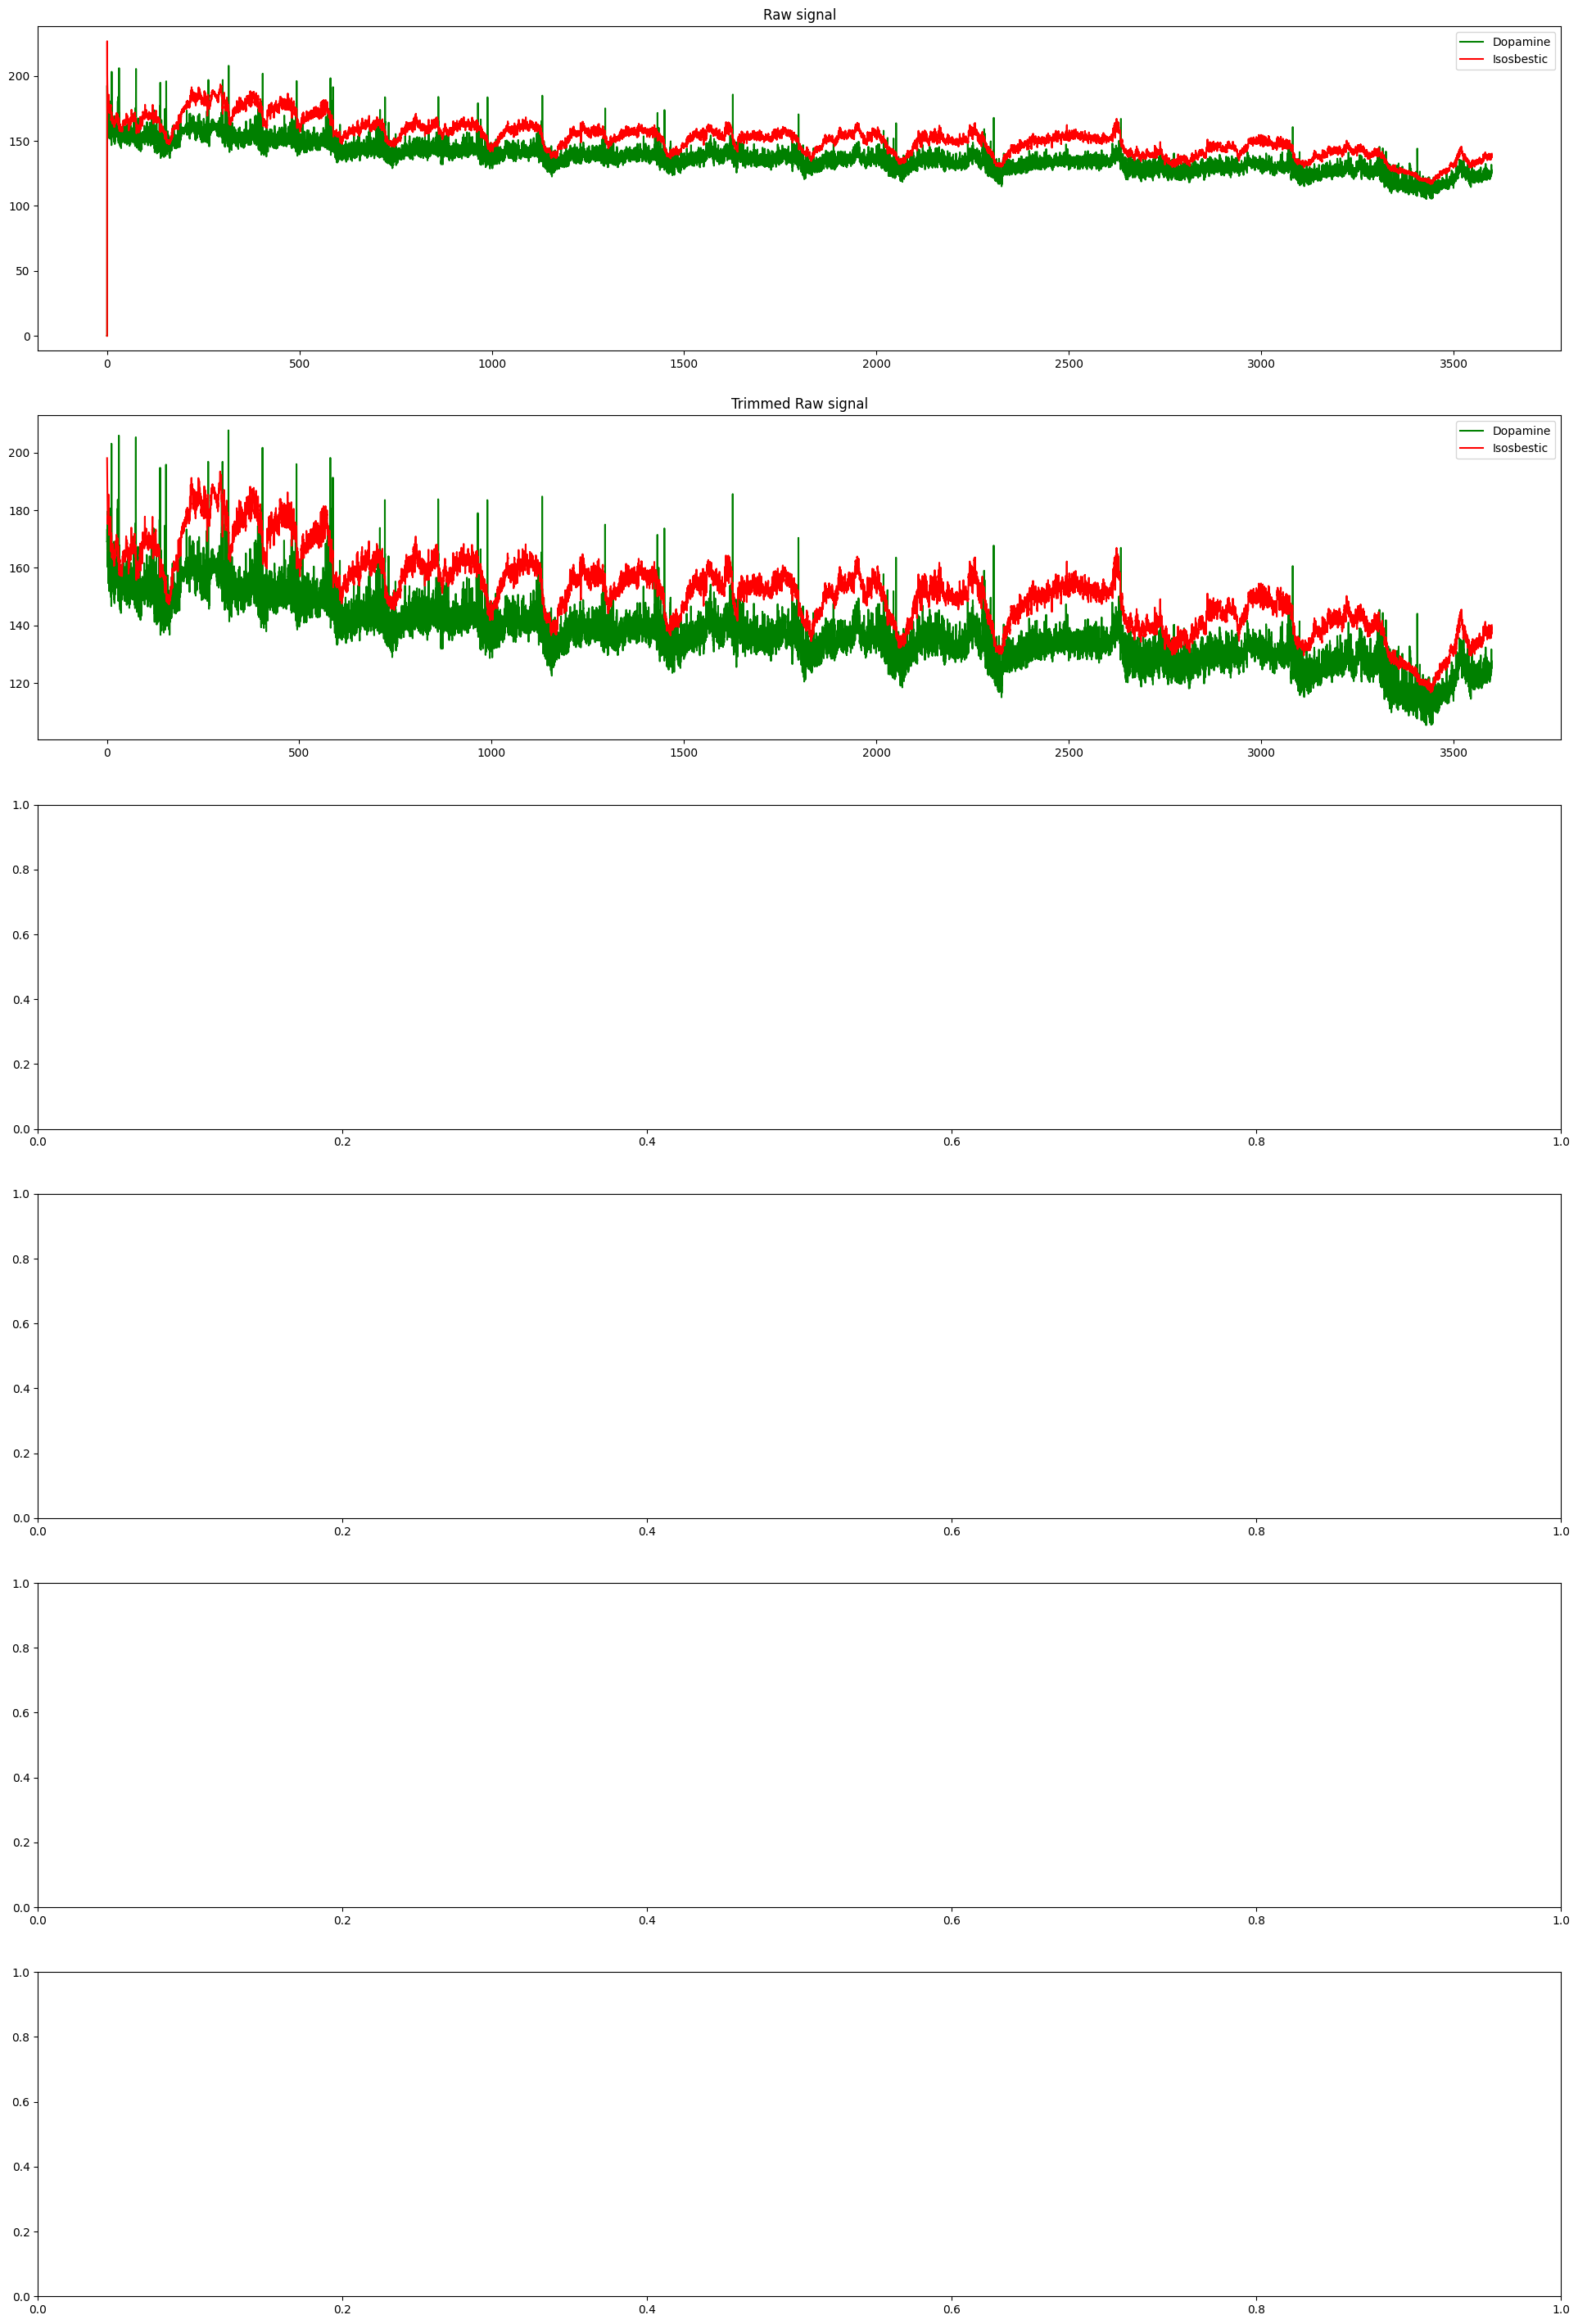

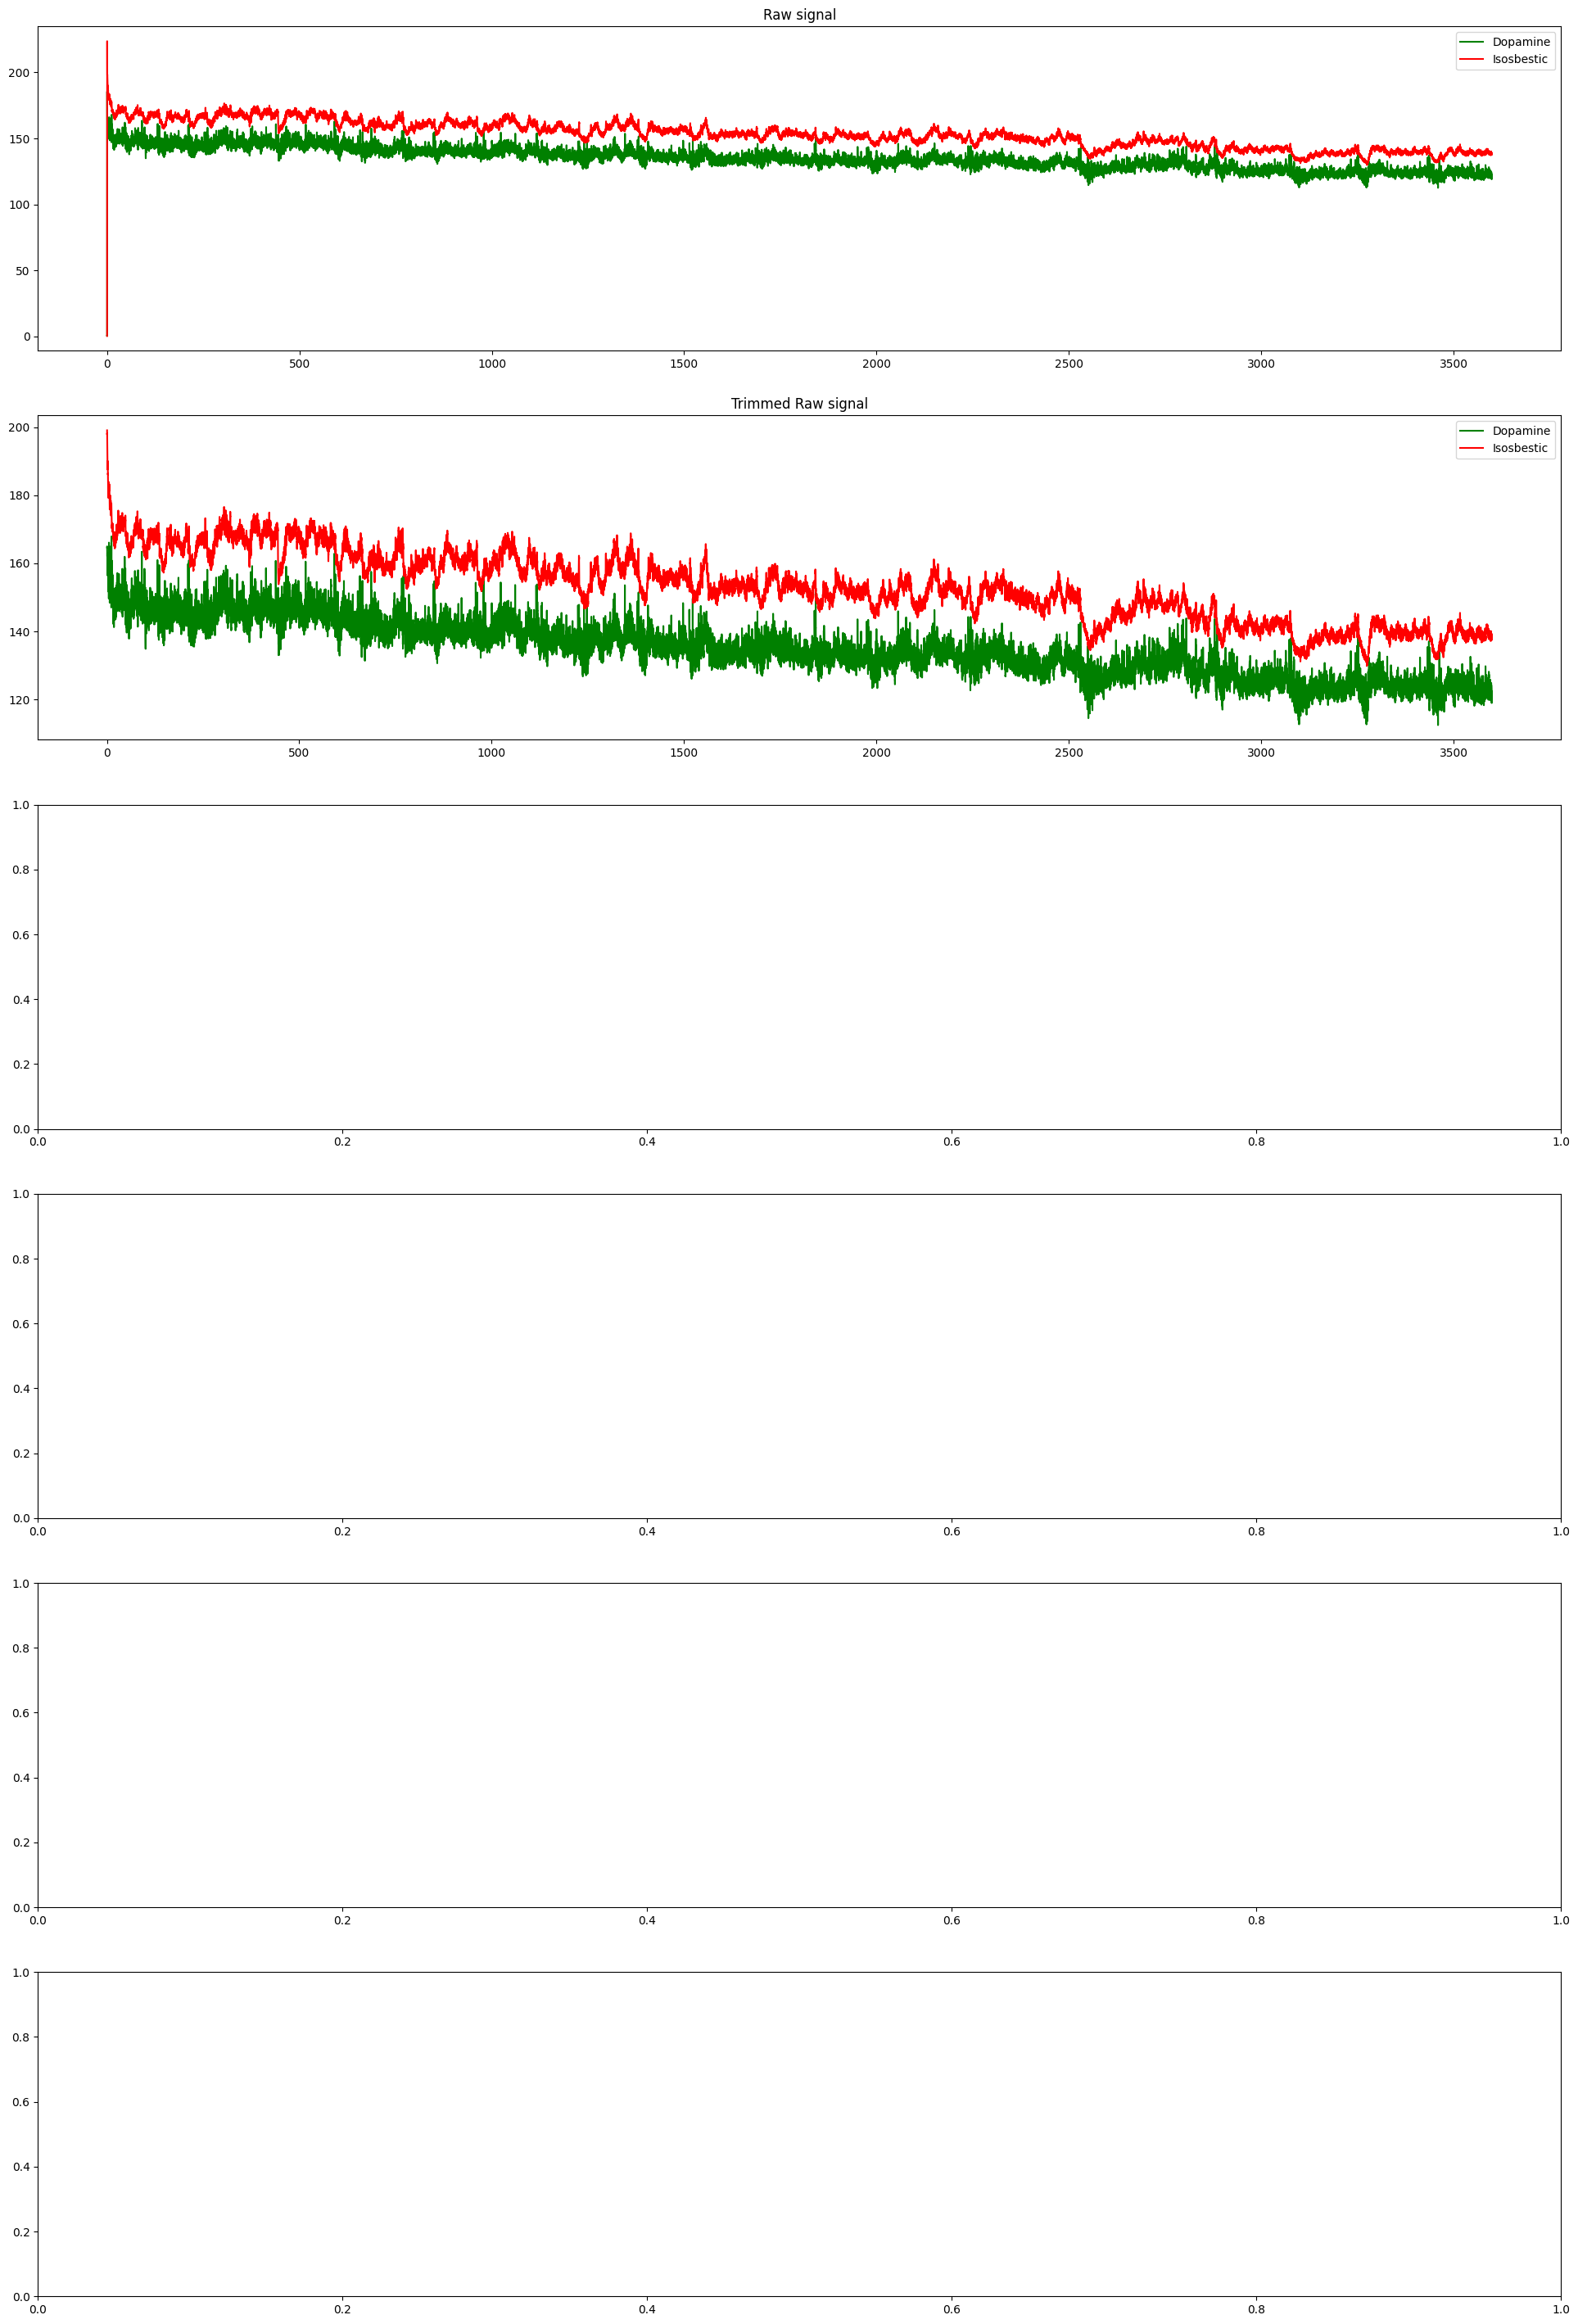

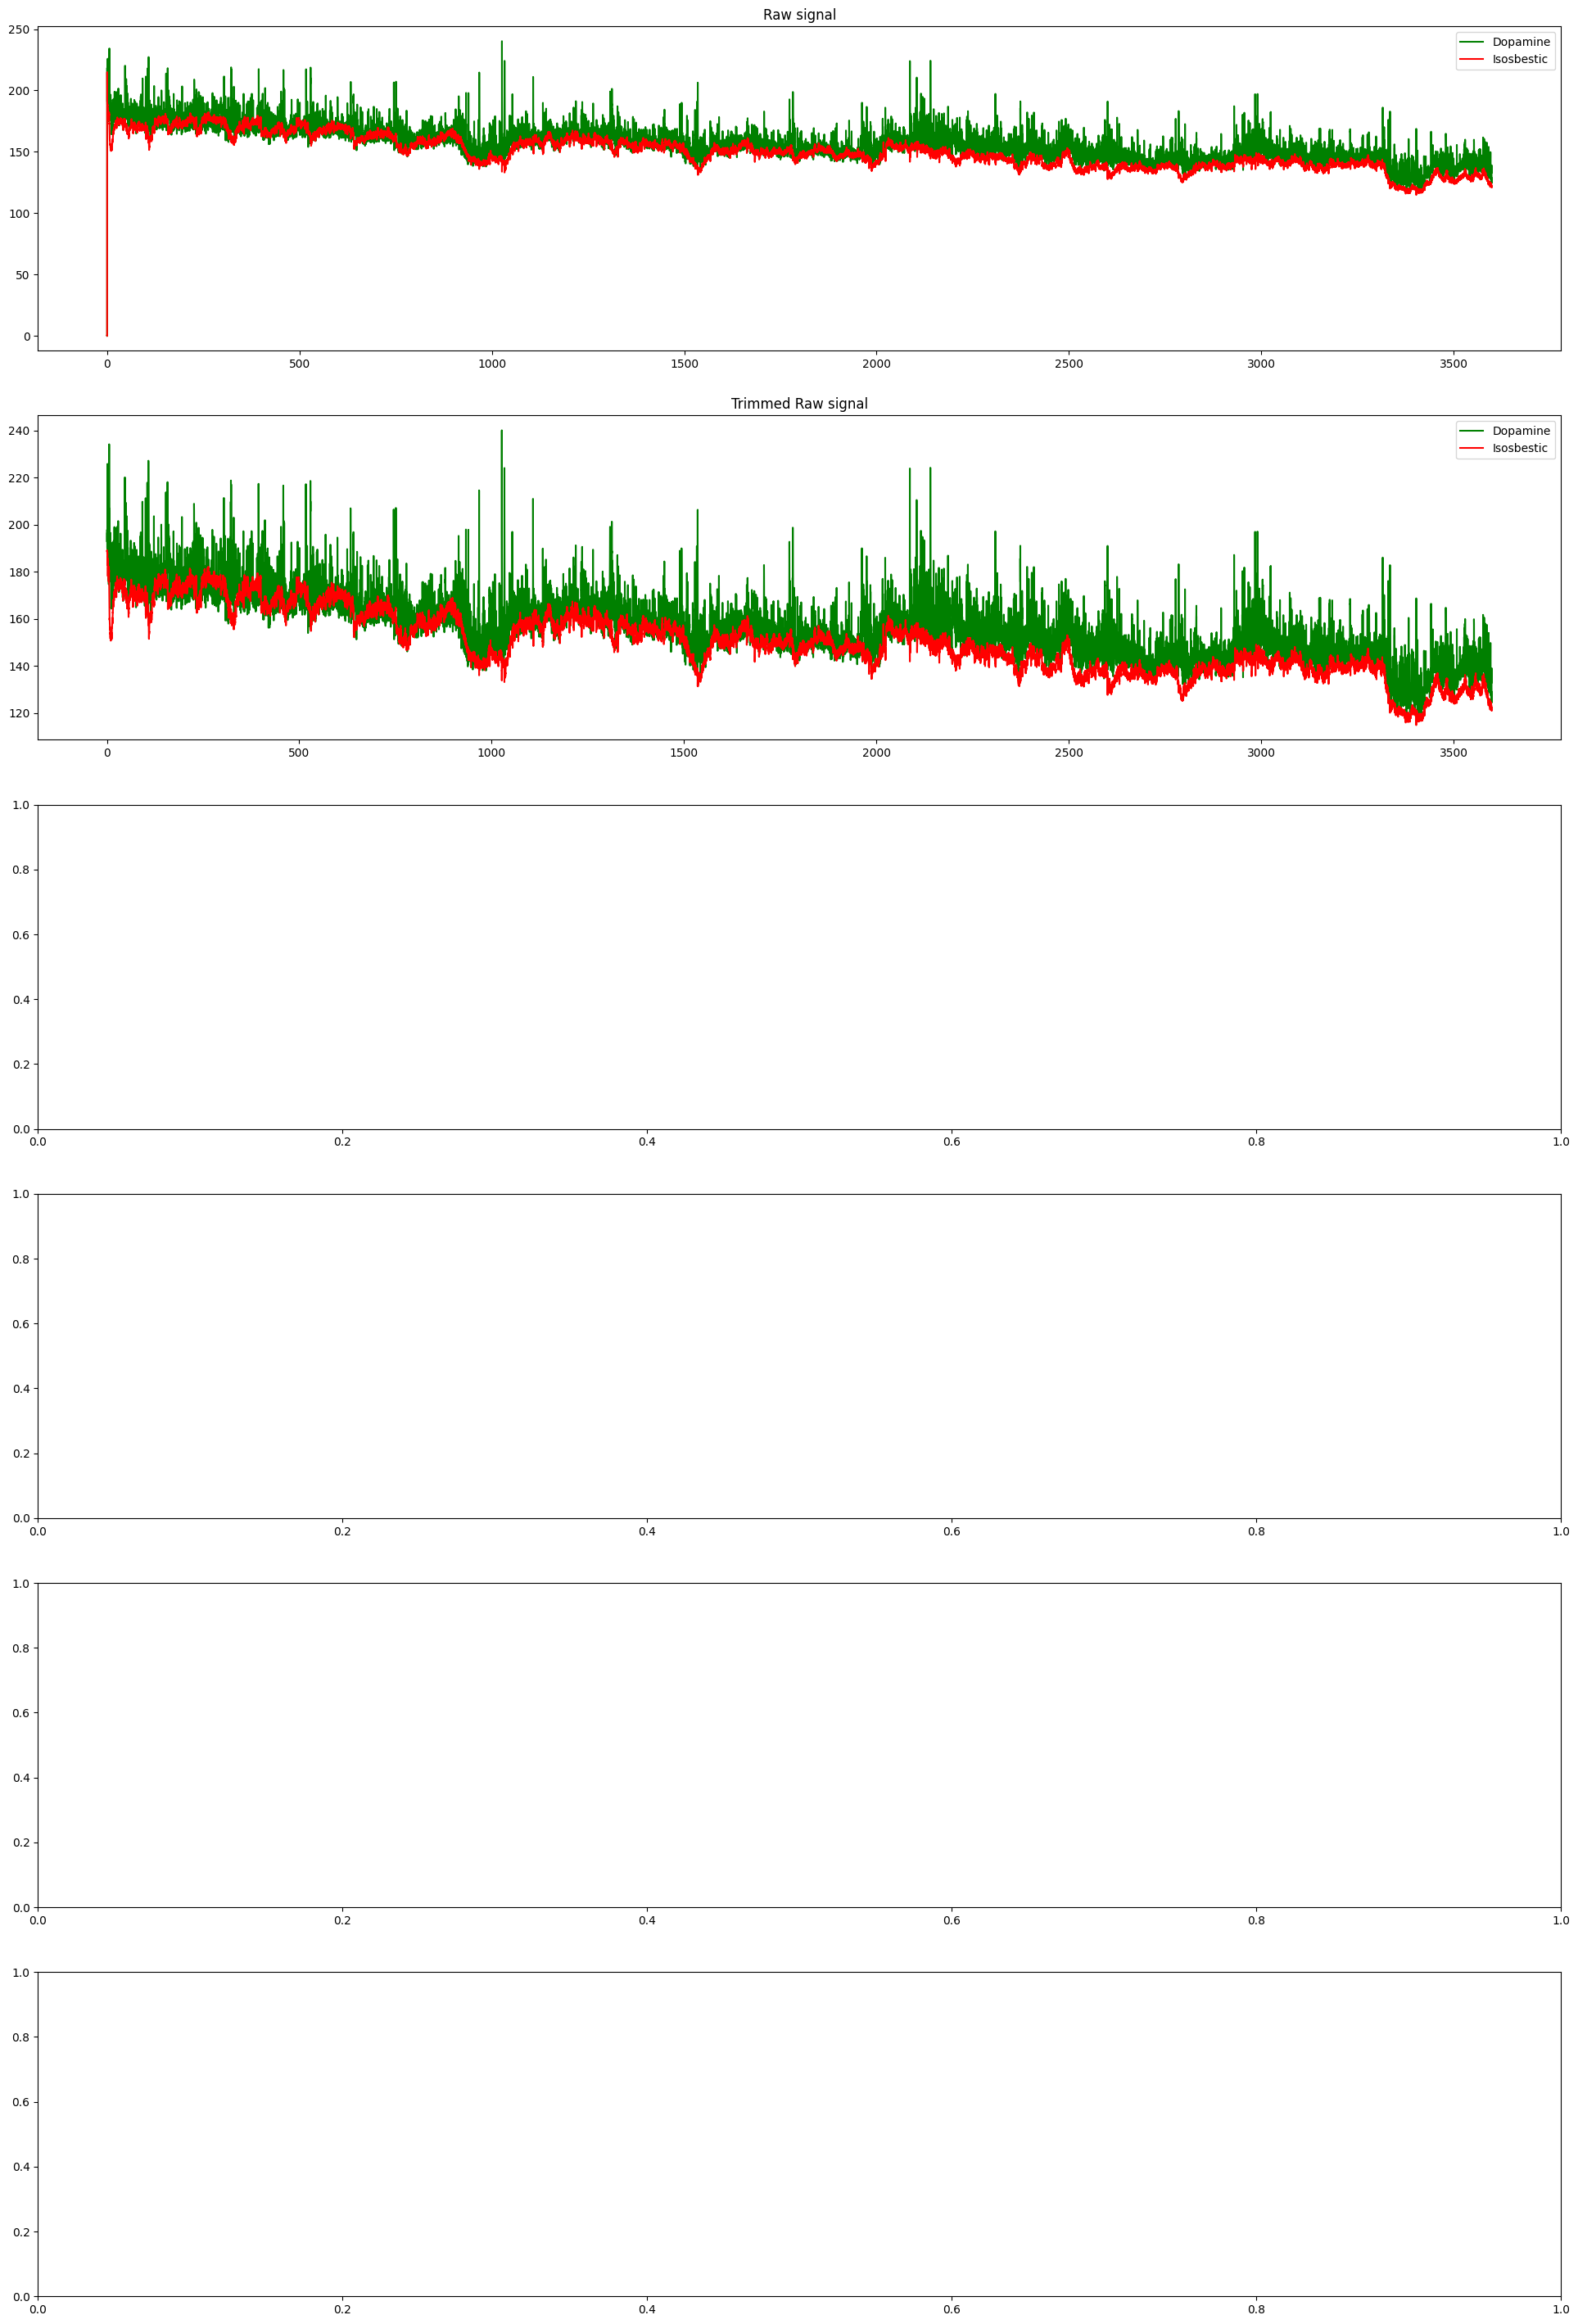

In [14]:
sessions = []
for p in glob.glob(r'M:\2024 July,Aug GRABDA2m data (DLS C1906Y)\Progressive Ratio tanks\PR day 2 *\*'):
    try:
        block = tdt.read_block(p)

        metadata = dict(block.info.items())
        dirname = os.path.basename(metadata['tankpath'])
        if 'Het' in dirname:
            metadata['genotype'] = 'Het'
        elif 'WT' in dirname:
            metadata['genotype'] = 'WT'
        else:
            raise RuntimeError('did not understand genotype')

        time, dopa, isob = preprocess(block, cache=True)

        sessions.append({
            'metadata': metadata,
            'signals': {
                'Time': time,
                'Dopamine': dopa,
                'Isosbestic': isob,
            },
            'events': {k: block.epocs[k].onset for k in block.epocs.keys()}
        })
    except Exception as e:
        print(f"skipping {p}:\n{e}")

print(sessions)


In [17]:
for session in sessions:
    session['event_aligned'] = {}
    session['event_aligned']['Dopamine@RNP'] = {}
    session['event_aligned']['Dopamine@RNP']['time'], session['event_aligned']['Dopamine@RNP']['signal'] = collect_signals(session['events']['RNP_'], session['signals']['Dopamine'], session['signals']['Time'], pre=3, post=5)

In [18]:
session['signals']['Dopamine']

array([7.33880591, 7.33222383, 7.32610012, ..., 1.53098849, 1.51935432,
       1.50785956])

In [19]:
time = sessions[0]['event_aligned']['Dopamine@RNP']['time']
all_rnp_sigs = np.vstack([session['event_aligned']['Dopamine@RNP']['signal'] for session in sessions])
wt_rnp_sigs = np.vstack([session['event_aligned']['Dopamine@RNP']['signal'] for session in sessions if session['metadata']['genotype'] == 'WT'])
het_rnp_sigs = np.vstack([session['event_aligned']['Dopamine@RNP']['signal'] for session in sessions if session['metadata']['genotype'] == 'Het'])
session_labels = np.hstack([[i] * session['event_aligned']['Dopamine@RNP']['signal'].shape[0] for i, session in enumerate(sessions)])

print(time.shape, all_rnp_sigs.shape, session_labels.shape)

(8138,) (284, 8138) (284,)


Text(0.5, 23.52222222222222, 'Time, Reletive to Event (sec)')

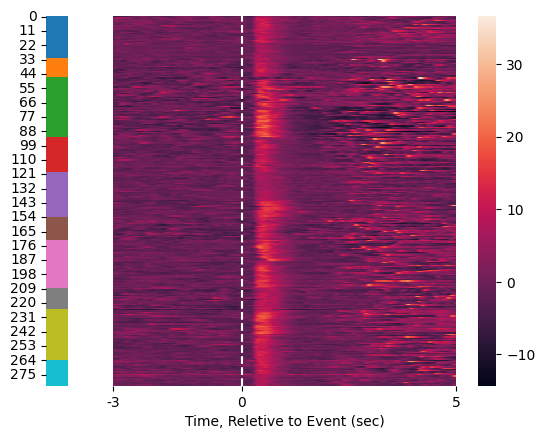

In [20]:
from fptools.viz import find_nearest
import seaborn as sns

fig, axs = plt.subplots(1, 2, width_ratios=(1, 20))

sns.heatmap(data=session_labels[:, None], cmap='tab10', ax=axs[0], cbar=False)
axs[0].set_xticks([])

sns.heatmap(data=all_rnp_sigs, ax=axs[1], cmap=None)
axs[1].axvline(find_nearest(time, 0), c='w', ls='--')

ticks = []
ticklabels = []
for t in [-3, 0, 5]:
    ticks.append(find_nearest(time, t))
    ticklabels.append(f'{t:0.0f}')
axs[1].set_xticks(ticks, labels=ticklabels, rotation=0)
axs[1].set_yticks([])
axs[1].set_xlabel('Time, Reletive to Event (sec)')

Text(0.5, 0, 'Time, Reletive to Event (s)')

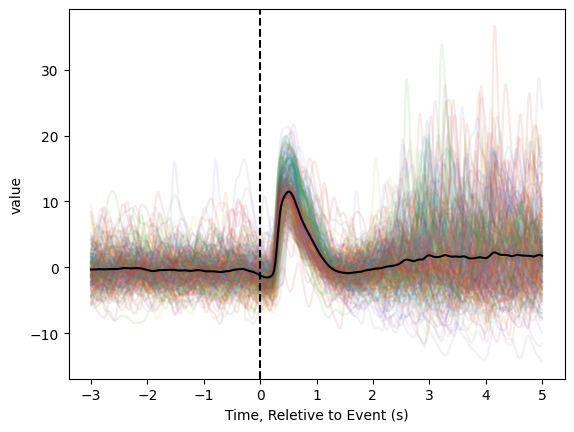

In [9]:
import pandas as pd

df = pd.DataFrame(all_rnp_sigs.T)
df.index = time
df = df.melt(ignore_index=False)

fig, ax = plt.subplots()

indv_colors = sns.color_palette('tab10', np.unique(session_labels).shape[0])


for i in range(all_rnp_sigs.shape[0]):
    sns.lineplot(data=None, x=time, y=all_rnp_sigs[i, :], alpha=0.1, ax=ax, color=indv_colors[session_labels[i]])

sns.lineplot(data=df, x=df.index, y='value', ax=ax, color='k')
ax.axvline(0, c='k', ls='--')
ax.set_xlabel('Time, Reletive to Event (s)')

Text(0.5, 0, 'Time, Reletive to Event (s)')

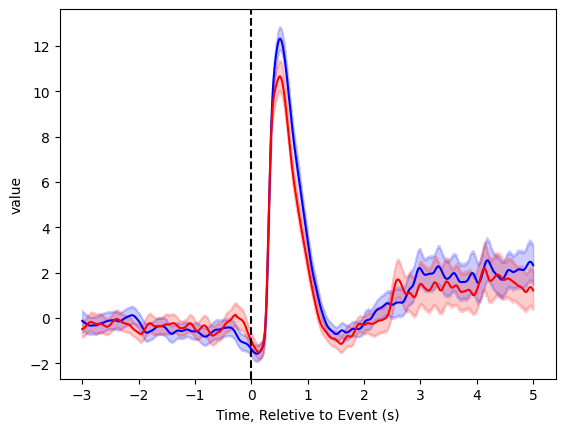

In [10]:
import pandas as pd

wt_df = pd.DataFrame(wt_rnp_sigs.T)
wt_df.index = time
wt_df = wt_df.melt(ignore_index=False)

het_df = pd.DataFrame(het_rnp_sigs.T)
het_df.index = time
het_df = het_df.melt(ignore_index=False)

fig, ax = plt.subplots()




sns.lineplot(data=wt_df, x=wt_df.index, y='value', ax=ax, color='b')
sns.lineplot(data=het_df, x=het_df.index, y='value', ax=ax, color='r')
ax.axvline(0, c='k', ls='--')
ax.set_xlabel('Time, Reletive to Event (s)')

In [11]:
for session in sessions:
    print(session['event_aligned']['Dopamine@RNP']['signal'].shape)

(21, 8138)
(11, 8138)
(15, 8138)
(23, 8138)
(23, 8138)
(27, 8138)
(21, 8138)
(13, 8138)
(18, 8138)
(16, 8138)
(21, 8138)
(16, 8138)
(19, 8138)
(20, 8138)
(11, 8138)
(9, 8138)


Text(0.5, 1.0, 'last 5 RNPs')

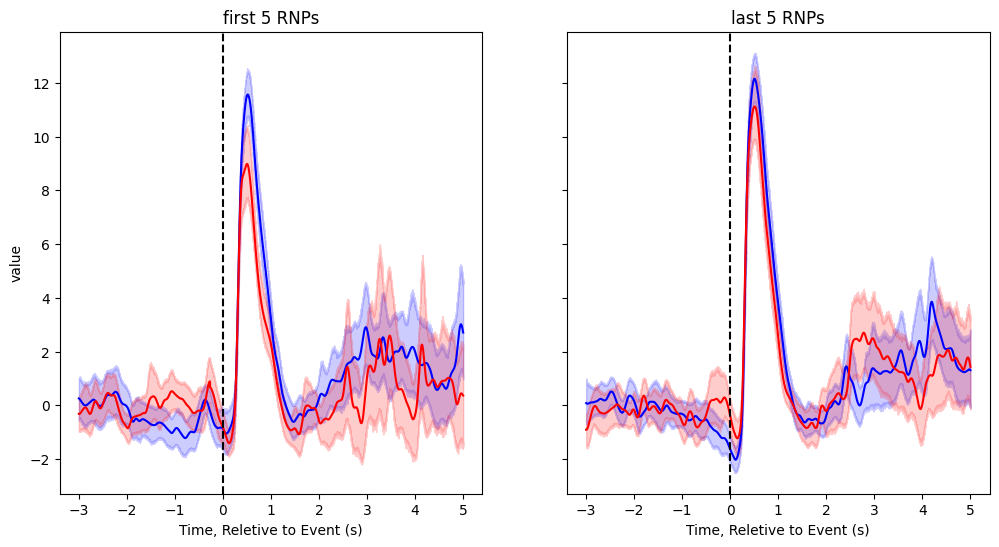

In [12]:
time = sessions[0]['event_aligned']['Dopamine@RNP']['time']

wt_rnp_sigs_first = np.vstack([session['event_aligned']['Dopamine@RNP']['signal'][0:5] for session in sessions if session['metadata']['genotype'] == 'WT'])
het_rnp_sigs_first = np.vstack([session['event_aligned']['Dopamine@RNP']['signal'][0:5] for session in sessions if session['metadata']['genotype'] == 'Het'])

wt_rnp_sigs_last = np.vstack([session['event_aligned']['Dopamine@RNP']['signal'][-5:] for session in sessions if session['metadata']['genotype'] == 'WT'])
het_rnp_sigs_last = np.vstack([session['event_aligned']['Dopamine@RNP']['signal'][-5:] for session in sessions if session['metadata']['genotype'] == 'Het'])


wt_df_first = pd.DataFrame(wt_rnp_sigs_first.T)
wt_df_first.index = time
wt_df_first = wt_df_first.melt(ignore_index=False)

wt_df_last = pd.DataFrame(wt_rnp_sigs_last.T)
wt_df_last.index = time
wt_df_last = wt_df_last.melt(ignore_index=False)

het_df_first = pd.DataFrame(het_rnp_sigs_first.T)
het_df_first.index = time
het_df_first = het_df_first.melt(ignore_index=False)

het_df_last = pd.DataFrame(het_rnp_sigs_last.T)
het_df_last.index = time
het_df_last = het_df_last.melt(ignore_index=False)

fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

sns.lineplot(data=wt_df_first, x=wt_df_first.index, y='value', ax=axs[0], color='b')
sns.lineplot(data=het_df_first, x=het_df_first.index, y='value', ax=axs[0], color='r')
axs[0].axvline(0, c='k', ls='--')
axs[0].set_xlabel('Time, Reletive to Event (s)')
axs[0].set_title('first 5 RNPs')


sns.lineplot(data=wt_df_last, x=wt_df_last.index, y='value', ax=axs[1], color='b')
sns.lineplot(data=het_df_last, x=het_df_last.index, y='value', ax=axs[1], color='r')
axs[1].axvline(0, c='k', ls='--')
axs[1].set_xlabel('Time, Reletive to Event (s)')
axs[1].set_title('last 5 RNPs')


In [51]:
peak_data = []

for session in sessions:
    t, sig = collect_signals(session['events']['RNP_'], session['signals']['Dopamine'], session['signals']['Time'], pre=0, post=2)
    for i in range(sig.shape[0]):
        peaks, props = scipy.signal.find_peaks(sig[i], prominence=5, distance=10000, height=(None,None))
        if len(peaks) > 1:
            print('found more than one peak!!')
        #print(peaks, props)
        peak_data.append({
            **session['metadata'],
            'RNP_i': i,
            'peak_i': peaks[0],
            'height': props['peak_heights'][0],
            'prominence': props['prominences'][0],
            'auc': metrics.auc(t, sig[i]),
        })

peak_data = pd.DataFrame(peak_data)
peak_data

,tankpath,blockname,start_date,utc_start_time,stop_date,utc_stop_time,duration,stream_channel,snip_channel,genotype,RNP_i,peak_i,height,prominence,auc
0,"M:\2024 July,Aug GRABDA2m data (DLS C1906Y)\Pr...",EN166_PRD2-240814-151808,2024-08-14 15:18:12.999999,15:18:12,2024-08-14 16:18:12.093490,16:18:12,0 days 00:59:59.093491,0,0,Het,0,603,6.129379,7.917329,1.431297
1,"M:\2024 July,Aug GRABDA2m data (DLS C1906Y)\Pr...",EN166_PRD2-240814-151808,2024-08-14 15:18:12.999999,15:18:12,2024-08-14 16:18:12.093490,16:18:12,0 days 00:59:59.093491,0,0,Het,1,390,10.107169,10.998638,5.752150
2,"M:\2024 July,Aug GRABDA2m data (DLS C1906Y)\Pr...",EN166_PRD2-240814-151808,2024-08-14 15:18:12.999999,15:18:12,2024-08-14 16:18:12.093490,16:18:12,0 days 00:59:59.093491,0,0,Het,2,476,13.205487,14.410100,6.138327
3,"M:\2024 July,Aug GRABDA2m data (DLS C1906Y)\Pr...",EN166_PRD2-240814-151808,2024-08-14 15:18:12.999999,15:18:12,2024-08-14 16:18:12.093490,16:18:12,0 days 00:59:59.093491,0,0,Het,3,405,11.014647,11.584127,6.779721
4,"M:\2024 July,Aug GRABDA2m data (DLS C1906Y)\Pr...",EN166_PRD2-240814-151808,2024-08-14 15:18:12.999999,15:18:12,2024-08-14 16:18:12.093490,16:18:12,0 days 00:59:59.093491,0,0,Het,4,531,11.785553,12.950381,5.187561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,"M:\2024 July,Aug GRABDA2m data (DLS C1906Y)\Pr...",EN188_PRD2-240816-110047,2024-08-16 11:00:52.999999,11:00:52,2024-08-16 12:00:52.201624,12:00:52,0 days 00:59:59.201625,0,0,WT,4,507,8.985409,11.188261,1.654190
280,"M:\2024 July,Aug GRABDA2m data (DLS C1906Y)\Pr...",EN188_PRD2-240816-110047,2024-08-16 11:00:52.999999,11:00:52,2024-08-16 12:00:52.201624,12:00:52,0 days 00:59:59.201625,0,0,WT,5,554,10.359775,13.614458,1.533554
281,"M:\2024 July,Aug GRABDA2m data (DLS C1906Y)\Pr...",EN188_PRD2-240816-110047,2024-08-16 11:00:52.999999,11:00:52,2024-08-16 12:00:52.201624,12:00:52,0 days 00:59:59.201625,0,0,WT,6,489,8.725405,9.569591,2.638483
282,"M:\2024 July,Aug GRABDA2m data (DLS C1906Y)\Pr...",EN188_PRD2-240816-110047,2024-08-16 11:00:52.999999,11:00:52,2024-08-16 12:00:52.201624,12:00:52,0 days 00:59:59.201625,0,0,WT,7,400,8.691216,11.393712,1.984857


<Axes: xlabel='RNP_i', ylabel='prominence'>

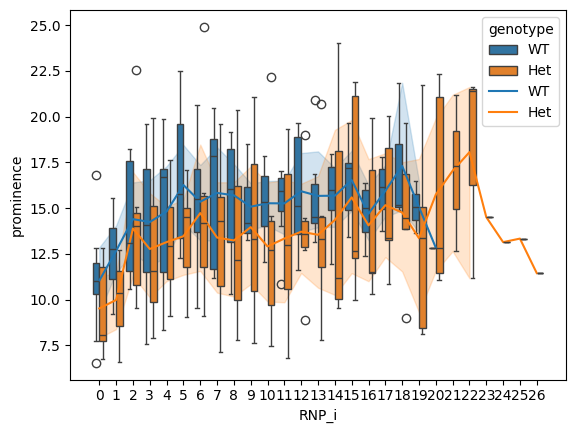

In [52]:
sns.boxplot(data=peak_data, x='RNP_i', y='prominence', hue='genotype', hue_order=['WT', 'Het'])
sns.lineplot(data=peak_data, x='RNP_i', y='prominence', hue='genotype', hue_order=['WT', 'Het'])

<Axes: xlabel='RNP_i', ylabel='height'>

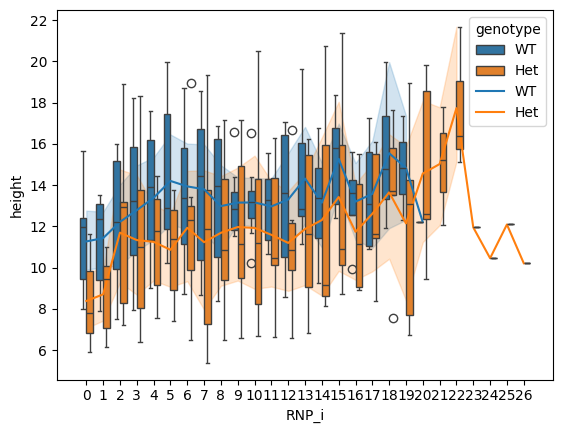

In [53]:
sns.boxplot(data=peak_data, x='RNP_i', y='height', hue='genotype', hue_order=['WT', 'Het'])
sns.lineplot(data=peak_data, x='RNP_i', y='height', hue='genotype', hue_order=['WT', 'Het'])

<Axes: xlabel='RNP_i', ylabel='auc'>

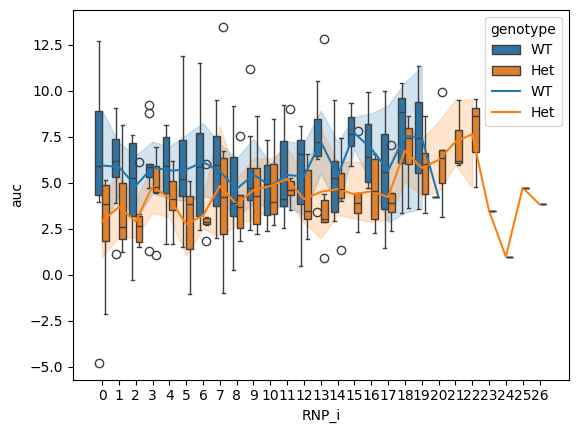

In [55]:
sns.boxplot(data=peak_data, x='RNP_i', y='auc', hue='genotype', hue_order=['WT', 'Het'])
sns.lineplot(data=peak_data, x='RNP_i', y='auc', hue='genotype', hue_order=['WT', 'Het'])

In [56]:
block.info.items()

dict_items([('tankpath', 'M:\\2024 July,Aug GRABDA2m data (DLS C1906Y)\\Progressive Ratio tanks\\PR day 2 WT'), ('blockname', 'EN188_PRD2-240816-110047'), ('start_date', datetime.datetime(2024, 8, 16, 11, 0, 52, 999999)), ('utc_start_time', '11:00:52'), ('stop_date', datetime.datetime(2024, 8, 16, 12, 0, 52, 201624)), ('utc_stop_time', '12:00:52'), ('duration', datetime.timedelta(seconds=3599, microseconds=201625)), ('stream_channel', 0), ('snip_channel', 0)])